In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

from fastmri_recon.data.oasis_sequences import Masked2DSequence
from fastmri_recon.helpers.evaluate import METRIC_FUNCS, Metrics
from fastmri_recon.helpers.reconstruction import reco_and_gt_zfilled_from_val_file, reco_and_gt_net_from_val_file
from fastmri_recon.models.cascading import cascade_net

Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# paths
train_path = '/media/Zaccharie/UHRes/OASIS_data/'

# generators
AF = 4
train_gen = Masked2DSequence(
    train_path,
    af=AF,
    inner_slices=32,
    scale_factor=1e-2,
    seed=0,
    rand=True,
    val_split=0.1,
)
val_gen = train_gen.val_sequence
n_train = 1000
n_val = 200

train_gen.filenames = train_gen.filenames[:n_train]
val_gen.filenames = val_gen.filenames[:n_val]

In [5]:
all_net_params = [
#     {
#         'name': 'unet',
#         'init_function': unet,
#         'run_params': {
#             'n_layers': 4,
#             'pool': 'max',
#             "layers_n_channels": [16, 32, 64, 128],
#             'layers_n_non_lins': 2,
#             'input_size': (320, 320, 1),
#         },
#         'val_gen': val_gen_zero,
#         'run_id': 'unet_af4_1569210349',
#     },
#     {
#         'name': 'pdnet',
#         'init_function': pdnet,
#         'run_params': {
#             'n_primal': 5,
#             'n_dual': 5,
#             'n_iter': 10,
#             'n_filters': 32,
#         },
#         'val_gen': val_gen_scaled,
#         'run_id': 'pdnet_af4_1568384763',
#     },
    {
        'name': 'cascadenet',
        'init_function': cascade_net,
        'run_params': {
            'n_cascade': 5,
            'n_convs': 5,
            'n_filters': 48,
            'noiseless': True,
        },
        'run_id': 'cascadenet_af4_oasis_1569491836',
    },
#     {
#         'name': 'kikinet',
#         'init_function': kiki_net,
#         'run_params': {
#             'n_cascade': 2,
#             'n_convs': 25,
#             'n_filters': 32,
#             'noiseless': True,
#         },
#         'val_gen': val_gen_scaled,
#         'run_id': 'kikinet_af4_1568724379',
#     },
]

In [6]:
def unpack_model(init_function=None, run_params=None, run_id=None, epoch=300, **dummy_kwargs):
    model = init_function(input_size=(None, None, 1), fastmri=False, **run_params)
    chkpt_path = f'../checkpoints/{run_id}-{epoch}.hdf5'
    model.load_weights(chkpt_path)
    return model

def metrics_for_params(name=None, **net_params):
    model = unpack_model(**net_params)
    metrics = Metrics(METRIC_FUNCS)
    pred_and_gt = [
        reco_and_gt_net_from_val_file(*val_gen[i], model)
        for i in tqdm_notebook(range(len(val_gen)), desc=f'Val files for {name}')
    ]    
    for im_recos, images in tqdm_notebook(pred_and_gt, desc=f'Stats for {name}'):
        metrics.push(images, im_recos)
    return metrics


def metrics_zfilled():
    metrics = Metrics(METRIC_FUNCS)
    pred_and_gt = [
        reco_and_gt_zfilled_from_val_file(*val_gen[i], crop=False)
        for i in tqdm_notebook(range(len(val_gen)), desc='Val files for z-filled')
    ]    
    for im_recos, images in tqdm_notebook(pred_and_gt, desc='Stats for z-filled'):
        metrics.push(images, im_recos)
    return metrics

In [7]:
%%time
metrics = []
for net_params in all_net_params:
    metrics.append((net_params['name'], metrics_for_params(**net_params)))
    
metrics.append(('zfilled', metrics_zfilled()))

W0927 10:31:48.912085 140235030689536 deprecation.py:323] From /volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/helpers/nn_mri.py:74: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


W0927 10:31:57.315635 140235030689536 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/keras/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.




CPU times: user 6min 50s, sys: 48.8 s, total: 7min 38s
Wall time: 7min


In [8]:
metrics

[('cascadenet', PSNR = 31.99 +/- 3.576 SSIM = 0.8903 +/- 0.06198),
 ('zfilled', PSNR = 26.22 +/- 2.695 SSIM = 0.6743 +/- 0.06209)]

In [9]:
metrics.sort(key=lambda x: x[1].metrics['PSNR'].mean())

In [10]:
# import pickle
# with open('metrics_net_rec_oasis', 'wb') as f:
#     pickle.dump(metrics, f)

<IPython.core.display.Javascript object>


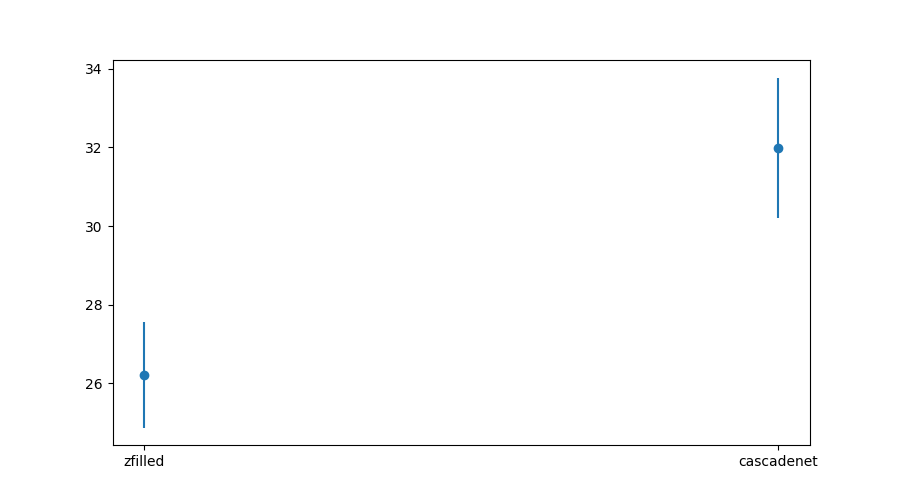

<ErrorbarContainer object of 3 artists>

In [11]:
plt.figure()
plt.errorbar(
    [name for name, _ in metrics], 
    [metric.metrics['PSNR'].mean() for _, metric in metrics], 
    [metric.metrics['PSNR'].stddev() for _, metric in metrics],
    linestyle='None', 
    marker='o',
)

<IPython.core.display.Javascript object>


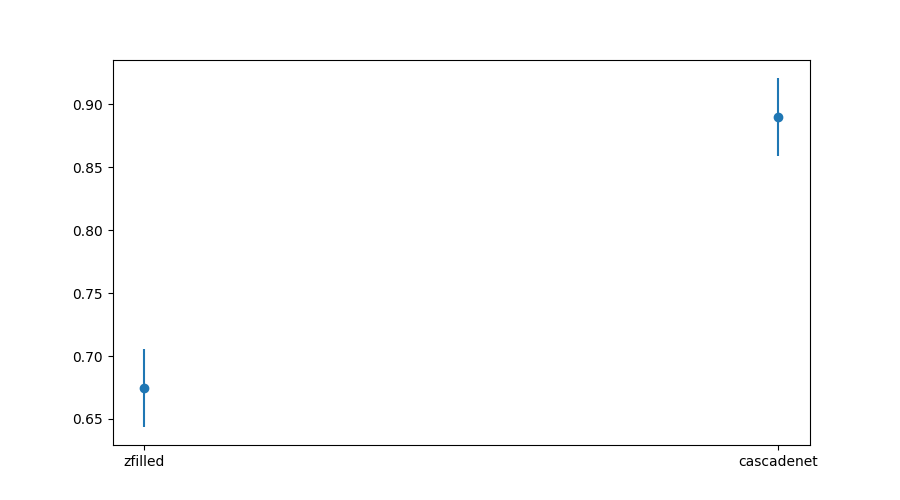

<ErrorbarContainer object of 3 artists>

In [12]:
plt.figure()
plt.errorbar(
    [name for name, _ in metrics], 
    [metric.metrics['SSIM'].mean() for _, metric in metrics], 
    [metric.metrics['SSIM'].stddev() for _, metric in metrics],
    linestyle='None', 
    marker='o',
)

In [13]:
def runtime_for_params(reco_function=None, val_gen=None, name=None, **net_params):
    model = unpack_model(**net_params)
    data = val_gen[0]
    start = time.time()
    reco_function(*data, model)
    end = time.time()
    return end - start

def runtime_zfilled():
    data = val_gen[0]
    start = time.time()
    reco_and_gt_zfilled_from_val_file(*data)
    end = time.time()
    return end - start

In [14]:
%%time
runtimes = []
for net_params in all_net_params:
    runtimes.append((net_params['name'], runtime_for_params(**net_params)))
    
runtimes.append(('zfilled', runtime_zfilled()))

TypeError: 'NoneType' object is not subscriptable